In [1]:
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  drive.mount('/content/drive')

  !pip install torchtext -qq
  !pip install transformers evaluate wandb datasets accelerate peft bitsandbytes -U -qq
  basepath = '/content/drive/MyDrive/NLP_HW7_Dipasha'
else:
  basepath = '/content/drive/MyDriveNLP_HW7_Dipasha'

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 47.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.4/302.4 kB 36.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.3/277.3 kB 32.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 43.6 MB

In [2]:
# standard data science librraies for data handling and v isualization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import multilabel_confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import numpy as np

import torch
import torch.nn as nn
from datasets import load_dataset
from transformers import (
    TrainingArguments,
    Trainer,
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AutoConfig,
    BitsAndBytesConfig,
)
from transformers import RobertaTokenizer, RobertaForSequenceClassification

import wandb
import evaluate

from sklearn.model_selection import train_test_split
import os

In [3]:
#Defining base and model folders
base_folder = Path(basepath)
data_folder = base_folder/'datasets'
model_folder = base_folder/'models'

In [4]:
data_folder = '/content/drive/MyDrive/NLP_HW7_Dipasha/datasets'
train_file = 'train.csv'
test_file = 'test.csv'

In [5]:
#Reading dataframes from given CSV
train_df = pd.read_csv(os.path.join(data_folder, train_file))
test_df = pd.read_csv(os.path.join(data_folder, test_file))

train_df.fillna(value={'Tweet': 'placeholder'}, inplace=True)
test_df.fillna(value={'Tweet': 'placeholder'}, inplace=True)

print("Number of rows in data =",train_df.shape[0])
print("Number of columns in data =",train_df.shape[1])

Number of rows in data = 7724
Number of columns in data = 13


In [6]:
train_df.head()

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2017-21441,“Worry is a down payment on a problem you may ...,0,1,0,0,0,0,1,0,0,0,1
1,2017-31535,Whatever you decide to do make sure it makes y...,0,0,0,0,1,1,1,0,0,0,0
2,2017-21068,@Max_Kellerman it also helps that the majorit...,1,0,1,0,1,0,1,0,0,0,0
3,2017-31436,Accept the challenges so that you can literall...,0,0,0,0,1,0,1,0,0,0,0
4,2017-22195,My roommate: it's okay that we can't spell bec...,1,0,1,0,0,0,0,0,0,0,0


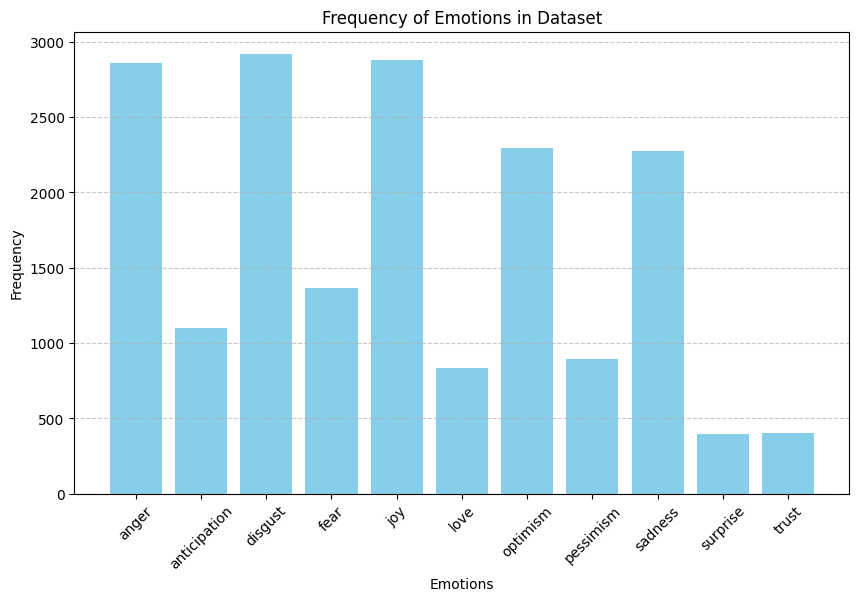

In [7]:
import matplotlib.pyplot as plt

emotions = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']
emotion_counts = train_df[emotions].sum()

plt.figure(figsize=(10, 6))
plt.bar(emotions, emotion_counts, color='skyblue')
plt.xlabel('Emotions')
plt.ylabel('Frequency')
plt.title('Frequency of Emotions in Dataset')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [8]:
train_df,val_df= train_test_split(train_df, test_size=0.2, random_state=42)

In [9]:
train_df.shape

(6179, 13)

In [10]:
val_df.shape

(1545, 13)

In [11]:
test_df.shape

(3259, 13)

In [12]:
X_train = train_df.drop(columns = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust'])
y_train = train_df[['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']].to_numpy()

In [13]:
X_val = val_df.drop(columns = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust'])
y_val = val_df[['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']].to_numpy()

In [14]:
test_df.replace('NONE', 0, inplace=True)
X_test = test_df.drop(columns = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust'])
y_test = test_df[['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']].to_numpy()

In [15]:
from datasets import Dataset

trainset = Dataset.from_dict({
    'texts': X_train['Tweet'],
    'labels': y_train
})

validset = Dataset.from_dict({
    'texts': X_val['Tweet'],
    'labels': y_val
})

testset = Dataset.from_dict({
    'texts': X_test['Tweet'],
    'labels': y_test
})

In [16]:
trainset.features

{'texts': Value(dtype='string', id=None),
 'labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}

In [17]:
trainset[:1]

{'texts': ["Going to get myself a copy of @StephenKing's CUJO for an upcoming project that I can't talk about just yet.  #amwriting"],
 'labels': [[0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0]]}

In [18]:
test_val_splits = trainset.train_test_split(test_size=0.4, seed=42)
train_split= test_val_splits['train']
test_val_splits = test_val_splits['test'].train_test_split(test_size=0.5, seed=42,)
val_split = test_val_splits['train']
test_split = test_val_splits['test']

In [19]:
train_split_small = train_split.shuffle(seed=42).select(range(2000))
val_split_small = val_split.shuffle(seed=42).select(range(500))
test_split_small = test_split.shuffle(seed=42).select(range(500))

In [20]:
from datasets import DatasetDict
# combine train, val splits into one dataset
train_val_dataset = DatasetDict({'train': train_split, 'val': val_split})

# create test dataset from test split
test_dataset = DatasetDict({'test': test_split})

# create subsets of train and val datasets
train_val_subset = DatasetDict({'train': train_split_small, 'val': val_split_small})

# create subset for test dataset
test_subset = DatasetDict({'test': test_split_small})



In [21]:
train_val_subset

DatasetDict({
    train: Dataset({
        features: ['texts', 'labels'],
        num_rows: 2000
    })
    val: Dataset({
        features: ['texts', 'labels'],
        num_rows: 500
    })
})

In [22]:
train_val_subset['train'].features


{'texts': Value(dtype='string', id=None),
 'labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}

In [23]:
from peft import (
    TaskType,
    LoraConfig,
    prepare_model_for_kbit_training,
    get_peft_model,
)

In [24]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) y
Token is valid (permission: write).
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in 

In [25]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

checkpoint = "intfloat/e5-mistral-7b-instruct"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
tokenizer.pad_token = tokenizer.eos_token


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/981 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

In [26]:
def tokenize_fn(batch):
    return tokenizer(text = batch["texts"], truncation=True)

In [27]:
tokenized_dataset = train_val_subset.map(tokenize_fn, batched=True)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [28]:
tokenized_dataset = tokenized_dataset.remove_columns(
    ['texts']
)

In [29]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    val: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 500
    })
})

In [30]:
accuracy_metric = evaluate.load('accuracy', 'multilabel')
f1 = evaluate.load('f1','multilabel')

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # logits= logits[0]
    # print(logits.shape)
    preds = (logits > 0).astype(int)
    accuracy = accuracy_metric.compute(predictions=preds, references=labels)
    f1_micro = f1.compute(predictions=preds, references=labels, average='micro')
    f1_macro = f1.compute(predictions=preds, references=labels, average='macro')
    return {'f1_micro':f1_micro['f1'],
            'f1_macro':f1_macro['f1'],
            'accuracy':accuracy['accuracy'],
            }

In [33]:
# Define the directory where model checkpoints will be saved
run_name = "emotions_mistral_qlora_im"
base_folder = Path(basepath)
model_folder = base_folder / "models"/run_name
# Create the directory if it doesn't exist
model_folder.mkdir(exist_ok=True, parents=True)

# Configure training parameters
training_args = TrainingArguments(
    # Training-specific configurations
    num_train_epochs=5,  # Total number of training epochs
    # Number of samples per training batch for each device
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    # gradient_accumulation_steps=4,

    weight_decay=0.1,  # Apply L2 regularization to prevent overfitting
    learning_rate=5e-6,  # Step size for the optimizer during training
    lr_scheduler_type='linear',
    warmup_steps=0,  # Number of warmup steps for the learning rate scheduler
    optim='adamw_torch',  # Optimizer,
    max_grad_norm = 1.0,

    # Checkpoint saving and model evaluation settings
    output_dir=str(model_folder),  # Directory to save model checkpoints
    evaluation_strategy='steps',  # Evaluate model at specified step intervals
    eval_steps=20,  # Perform evaluation every 10 training steps
    save_strategy="steps",  # Save model checkpoint at specified step intervals
    save_steps=20,  # Save a model checkpoint every 10 training steps
    load_best_model_at_end=True,  # Reload the best model at the end of training
    save_total_limit=2,  # Retain only the best and the most recent model checkpoints
    # Use 'accuracy' as the metric to determine the best model
    metric_for_best_model="eval_f1_macro",
    greater_is_better=True,  # A model is 'better' if its accuracy is higher


    # Experiment logging configurations (commented out in this example)
    logging_strategy='steps',
    logging_steps=20,
    report_to='wandb',  # Log metrics and results to Weights & Biases platform
    run_name=run_name,  # Experiment name for Weights & Biases

    fp16=False,
    bf16=True,
    tf32= False
)




In [34]:
bnb_config = BitsAndBytesConfig(
  load_in_4bit=True,
  llm_int8_skip_modules = ['score'],
  bnb_4bit_quant_type="nf4",
  bnb_4bit_use_double_quant=True,
  bnb_4bit_compute_dtype=torch.bfloat16
)

In [35]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint,
                                                           num_labels=11,
                                                           problem_type="multi_label_classification",
                                                           quantization_config=bnb_config)

model = prepare_model_for_kbit_training(model)

config = AutoConfig.from_pretrained(checkpoint)
id2label= {id_: label_ for id_, label_ in enumerate(emotions)}
label2id = {label_: id_ for id_, label_ in enumerate(emotions)}
config.id2label = id2label
config.label2id = label2id
model.config = config
model.config.pad_token_id = tokenizer.pad_token_id
model


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now set to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/23.3k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.28G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of MistralForSequenceClassification were not initialized from the model checkpoint at intfloat/e5-mistral-7b-instruct and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


MistralForSequenceClassification(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096, padding_idx=2)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): M

In [36]:
model

MistralForSequenceClassification(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096, padding_idx=2)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): M

In [37]:
model.config

MistralConfig {
  "_name_or_path": "intfloat/e5-mistral-7b-instruct",
  "architectures": [
    "MistralModel"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "eos_token_id": 2,
  "hidden_act": "silu",
  "hidden_size": 4096,
  "id2label": {
    "0": "anger",
    "1": "anticipation",
    "2": "disgust",
    "3": "fear",
    "4": "joy",
    "5": "love",
    "6": "optimism",
    "7": "pessimism",
    "8": "sadness",
    "9": "surprise",
    "10": "trust"
  },
  "initializer_range": 0.02,
  "intermediate_size": 14336,
  "label2id": {
    "anger": 0,
    "anticipation": 1,
    "disgust": 2,
    "fear": 3,
    "joy": 4,
    "love": 5,
    "optimism": 6,
    "pessimism": 7,
    "sadness": 8,
    "surprise": 9,
    "trust": 10
  },
  "max_position_embeddings": 32768,
  "model_type": "mistral",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "num_key_value_heads": 8,
  "pad_token_id": 2,
  "rms_norm_eps": 1e-05,
  "rope_theta": 10000.0,
  "sliding_window": 4096,
  "tie_word_emb

In [38]:
import re
model_modules = str(model.modules)
pattern = r'\((\w+)\): Linear'
linear_layer_names = re.findall(pattern, model_modules)

names = []
# Print the names of the Linear layers
for name in linear_layer_names:
    names.append(name)
target_modules = list(set(names))
target_modules


['k_proj',
 'up_proj',
 'score',
 'q_proj',
 'o_proj',
 'down_proj',
 'gate_proj',
 'v_proj']

In [39]:
mistral_peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=128,
    lora_alpha=256,
    lora_dropout=0.01,
    bias="lora_only",
    modules_to_save = ['score'],
    target_modules = ['v_proj',  'q_proj',  'up_proj', 'o_proj', 'down_proj', 'gate_proj','k_proj'])

mistral_qlora_model = get_peft_model(model, mistral_peft_config )
mistral_qlora_model.print_trainable_parameters()

trainable params: 335,589,376 || all params: 7,446,294,528 || trainable%: 4.506796967781718


In [40]:
mistral_peft_config.target_modules

{'down_proj', 'gate_proj', 'k_proj', 'o_proj', 'q_proj', 'up_proj', 'v_proj'}

In [41]:
mistral_qlora_model

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): MistralForSequenceClassification(
      (model): MistralModel(
        (embed_tokens): Embedding(32000, 4096, padding_idx=2)
        (layers): ModuleList(
          (0-31): 32 x MistralDecoderLayer(
            (self_attn): MistralSdpaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.01, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=128, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=128, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): l

In [42]:
def calculate_pos_weights(dataset):
    # Initialize counters for all labels
    num_labels = len(dataset['train']['labels'][0])
    total_positives = [0] * num_labels
    total_negatives = [0] * num_labels

    # Count positives and negatives for each label
    for label_array in dataset['train']['labels']:
        for i, label in enumerate(label_array):
            if label == 1:
                total_positives[i] += 1
            else:
                total_negatives[i] += 1

    # Calculate pos_weight for each label
    pos_weight = [total_negatives[i] / max(total_positives[i], 1) for i in range(num_labels)]
    return torch.tensor(pos_weight)

# Calculate the pos_weight using the training set
pos_weights = calculate_pos_weights(tokenized_dataset)


In [43]:
pos_weights

tensor([ 1.6490,  5.8966,  1.5381,  4.6180,  1.6810,  8.0498,  2.3784,  7.4746,
         2.4247, 17.1818, 20.7391])

In [44]:
pos_weights= torch.tensor([2., 3., 2., 2., 2., 3., 2., 3., 2., 4., 4.])

In [45]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels").float()  # Ensure labels are float for BCE loss
        outputs = model(**inputs)
        logits = outputs.get("logits")

        device = next(model.parameters()).device

        loss_fct = nn.BCEWithLogitsLoss(pos_weight=pos_weights.to(device))
        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss


In [46]:
trainer = CustomTrainer(
    model=mistral_qlora_model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["val"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,

)

In [47]:
wandb.login()
%env WANDB_PROJECT = emotions_kaggle_S2024

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


env: WANDB_PROJECT=emotions_kaggle_S2024


In [48]:
trainer.train()  # start training

wandb: Currently logged in as: dipasha-ds (ds1213). Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss,F1 Micro,F1 Macro,Accuracy
20,1.508800,0.940341,0.377457,0.284111,0.008000
40,0.838300,0.762119,0.483261,0.286206,0.046000
60,0.726100,0.667685,0.563891,0.386564,0.100000
80,0.602000,0.604046,0.609137,0.468461,0.154000
100,0.551500,0.572248,0.618347,0.501654,0.110000
120,0.501500,0.548489,0.640127,0.532689,0.154000
140,0.472000,0.558406,0.657167,0.538494,0.216000
160,0.424700,0.547288,0.649805,0.559204,0.184000
180,0.415200,0.547753,0.656464,0.565022,0.166000
200,0.359500,0.562704,0.653507,0.563928,0.186000


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=T

TrainOutput(global_step=315, training_loss=0.506500316044641, metrics={'train_runtime': 648.6383, 'train_samples_per_second': 15.417, 'train_steps_per_second': 0.486, 'total_flos': 2.364514008170496e+16, 'train_loss': 0.506500316044641, 'epoch': 5.0})

In [49]:
eval_results = trainer.evaluate(tokenized_dataset["val"])

In [50]:
eval_results

{'eval_loss': 0.6698865294456482,
 'eval_f1_micro': 0.6584362139917694,
 'eval_f1_macro': 0.5754853700009219,
 'eval_accuracy': 0.178,
 'eval_runtime': 5.8549,
 'eval_samples_per_second': 85.398,
 'eval_steps_per_second': 2.733,
 'epoch': 5.0}

In [51]:
wandb.log({"eval_accuracy": eval_results["eval_accuracy"], "eval_loss": eval_results["eval_loss"],
"eval_f1_micro": eval_results["eval_f1_micro"], "eval_f1_macro": eval_results["eval_f1_macro"]})

In [52]:
valid_output = trainer.predict(tokenized_dataset["val"])

In [53]:
predictions_valid = (valid_output.predictions > 0).astype(int)
labels_valid = valid_output.label_ids.astype(int)

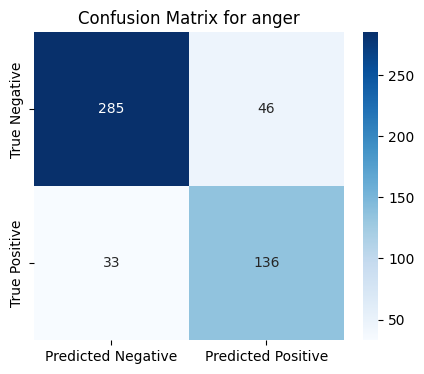

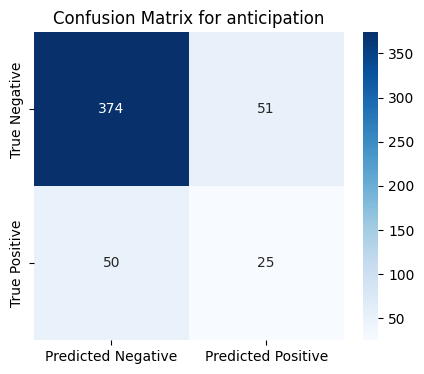

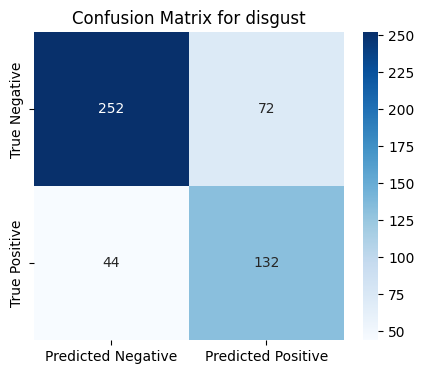

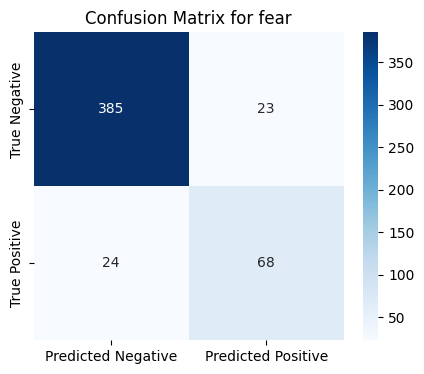

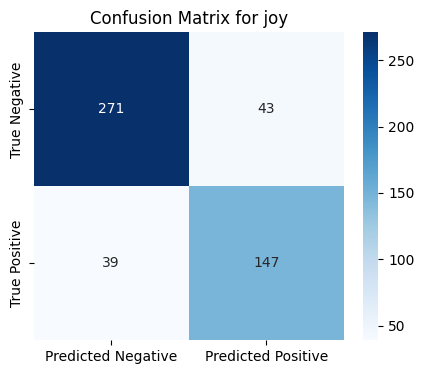

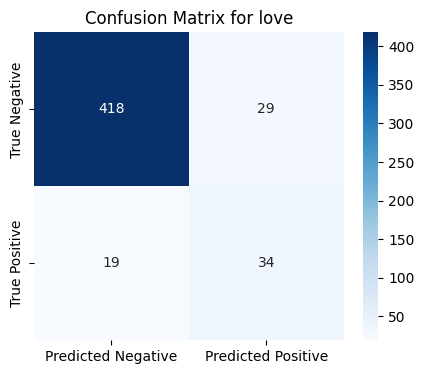

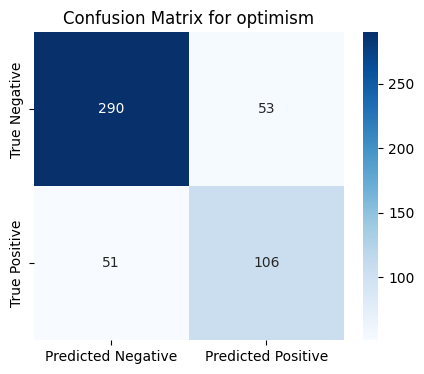

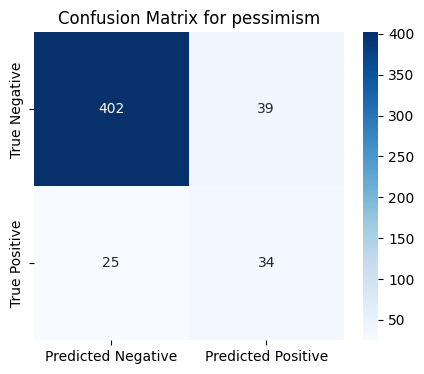

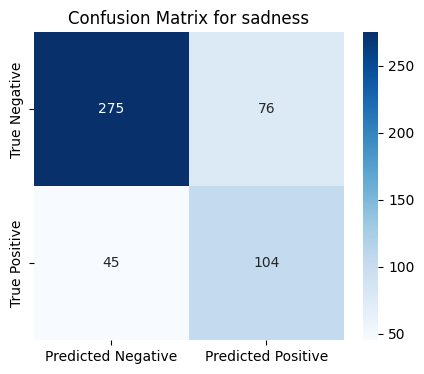

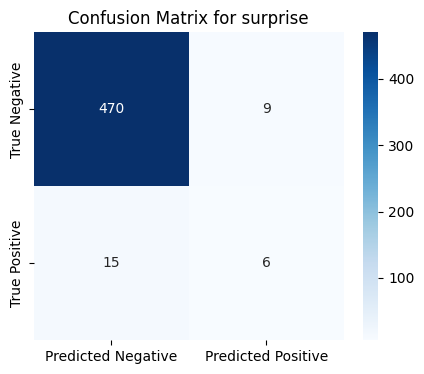

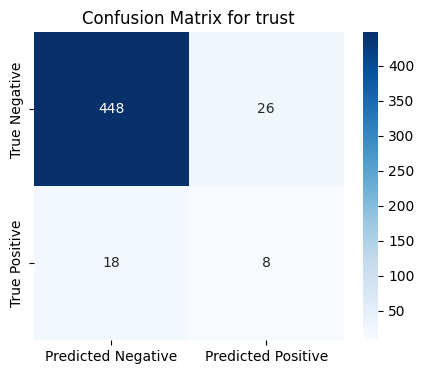

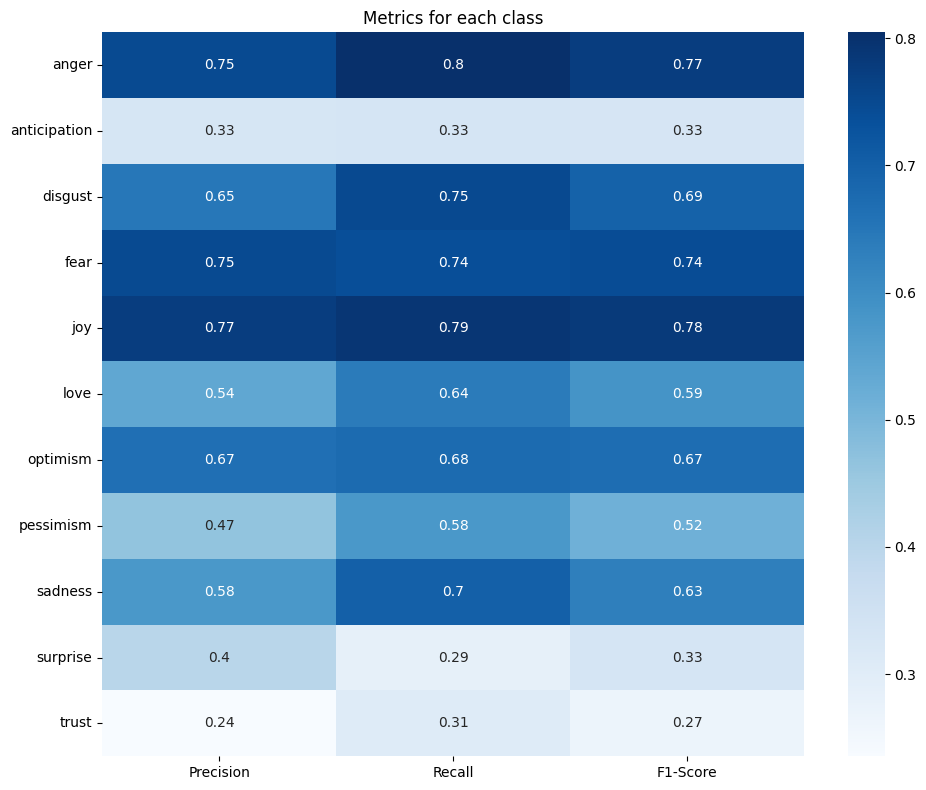

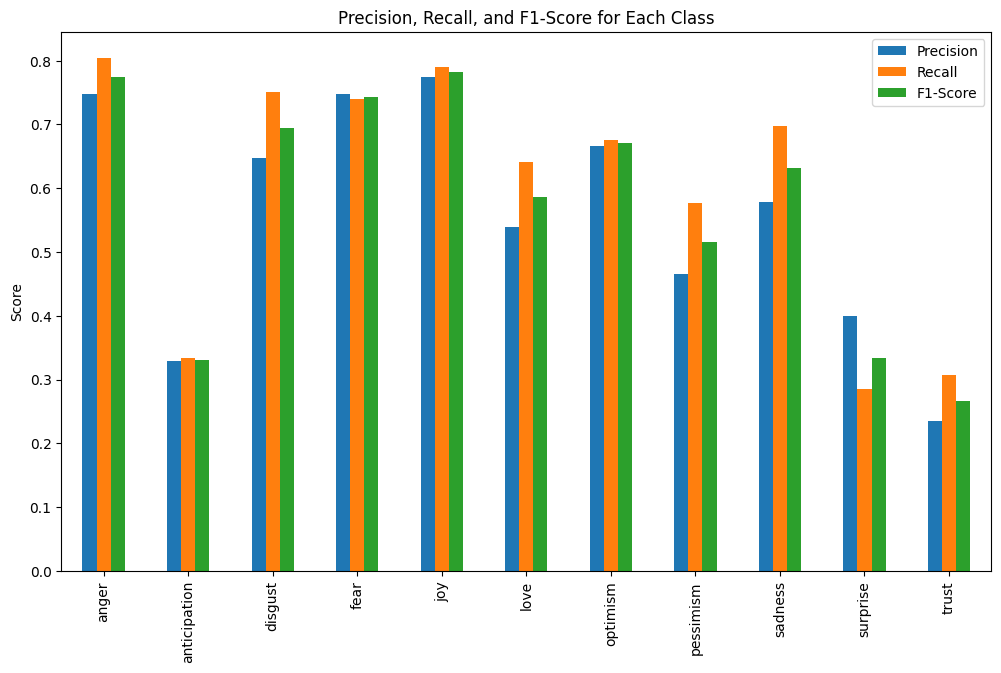

In [54]:
y_true = labels_valid
y_pred = predictions_valid
class_names = emotions

mcm = multilabel_confusion_matrix(y_true, y_pred,)

# 1. Individual Heatmaps
for idx, matrix in enumerate(mcm):
    plt.figure(figsize=(5, 4))
    sns.heatmap(matrix, annot=True, fmt='g', cmap='Blues',
                xticklabels=['Predicted Negative', 'Predicted Positive'],
                yticklabels=['True Negative', 'True Positive'])
    plt.title(f'Confusion Matrix for {class_names[idx]}')
    plt.show()

# 2. Aggregate Metrics Heatmap
precision_per_class = precision_score(y_true, y_pred, average=None)
recall_per_class = recall_score(y_true, y_pred, average=None)
f1_per_class = f1_score(y_true, y_pred, average=None)

metrics_df = pd.DataFrame({
    'Precision': precision_per_class,
    'Recall': recall_per_class,
    'F1-Score': f1_per_class
}, index=class_names)

plt.figure(figsize=(10, 8))
# sns.heatmap(metrics_df, annot=True, cmap='Blues')
# plt.title('Metrics for each class')
# plt.show()

ax = sns.heatmap(metrics_df, annot=True, cmap='Blues')
plt.title('Metrics for each class')
plt.tight_layout()  # Adjust layout to not cut off edges

# Log the heatmap to wandb
wandb.log({"Metrics Heatmap": wandb.Image(ax.get_figure())})
plt.show()

# 3. Histogram of Metrics
metrics_df.plot(kind='bar', figsize=(12, 7))
plt.ylabel('Score')
plt.title('Precision, Recall, and F1-Score for Each Class')
plt.show()




In [55]:
wandb.log({"Metrics Heatmap": wandb.Image(ax.get_figure())})


In [56]:
wandb.finish()

eval/accuracy,▁▂▄▆▄▆█▇▆▇▇▆▇▇▇▇
eval/f1_macro,▁▁▃▅▆▇▇█████████
eval/f1_micro,▁▄▆▇▇▇██████████
eval/loss,█▅▃▂▁▁▁▁▁▁▂▂▂▃▃▃
eval/runtime,▃▅▃▃▃▄▂▁▅▄▂▁▂▂▂█
eval/samples_per_second,▆▄▆▆▆▅▇█▄▅▇█▇▇▇▁
eval/steps_per_second,▆▄▆▆▆▆▇█▄▅▇█▇▇▇▁
eval_accuracy,▁
eval_f1_macro,▁
eval_f1_micro,▁
eval_loss,▁


In [57]:
from huggingface_hub import notebook_login
notebook_login()

In [58]:
mistral_qlora_model.push_to_hub("dsodhia/mistral_qlora_model")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


adapter_model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/dsodhia/mistral_qlora_model/commit/34a00fd536f1f0f48f88f7ef056af2ae397d2d19', commit_message='Upload model', commit_description='', oid='34a00fd536f1f0f48f88f7ef056af2ae397d2d19', pr_url=None, pr_revision=None, pr_num=None)

In [59]:
id2label = {}
for id_, label_ in enumerate(emotions):
    id2label[str(id_)] = label_
id2label


{'0': 'anger',
 '1': 'anticipation',
 '2': 'disgust',
 '3': 'fear',
 '4': 'joy',
 '5': 'love',
 '6': 'optimism',
 '7': 'pessimism',
 '8': 'sadness',
 '9': 'surprise',
 '10': 'trust'}

In [60]:
label2id = {}
for id_, label_ in enumerate(emotions):
    label2id[label_] = id_
label2id


{'anger': 0,
 'anticipation': 1,
 'disgust': 2,
 'fear': 3,
 'joy': 4,
 'love': 5,
 'optimism': 6,
 'pessimism': 7,
 'sadness': 8,
 'surprise': 9,
 'trust': 10}

In [61]:
import torch
from peft import PeftModel, PeftConfig

peft_model_id = "dsodhia/mistral_qlora_model"
config = PeftConfig.from_pretrained(peft_model_id)
config.base_model_name_or_path
base_model = AutoModelForSequenceClassification.from_pretrained(config.base_model_name_or_path,
                                                                num_labels=11,
                                                                problem_type="multi_label_classification")
tokenizer = AutoTokenizer.from_pretrained(config.base_model_name_or_path)


adapter_config.json:   0%|          | 0.00/752 [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of MistralForSequenceClassification were not initialized from the model checkpoint at intfloat/e5-mistral-7b-instruct and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [62]:
base_model

MistralForSequenceClassification(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096, padding_idx=2)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): MistralRMSNorm()
      )
    

In [63]:
# Load the Lora model
inference_model = PeftModel.from_pretrained(base_model, peft_model_id)

adapter_model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

In [64]:
inference_model

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): MistralForSequenceClassification(
      (model): MistralModel(
        (embed_tokens): Embedding(32000, 4096, padding_idx=2)
        (layers): ModuleList(
          (0-31): 32 x MistralDecoderLayer(
            (self_attn): MistralSdpaAttention(
              (q_proj): lora.Linear(
                (base_layer): Linear(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.01, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=128, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=128, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Line

In [65]:
inference_model.config.id2label = id2label
inference_model.config.label2id = label2id

In [66]:
inference_model.config

MistralConfig {
  "_name_or_path": "intfloat/e5-mistral-7b-instruct",
  "architectures": [
    "MistralModel"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "eos_token_id": 2,
  "hidden_act": "silu",
  "hidden_size": 4096,
  "id2label": {
    "0": "anger",
    "1": "anticipation",
    "10": "trust",
    "2": "disgust",
    "3": "fear",
    "4": "joy",
    "5": "love",
    "6": "optimism",
    "7": "pessimism",
    "8": "sadness",
    "9": "surprise"
  },
  "initializer_range": 0.02,
  "intermediate_size": 14336,
  "label2id": {
    "anger": 0,
    "anticipation": 1,
    "disgust": 2,
    "fear": 3,
    "joy": 4,
    "love": 5,
    "optimism": 6,
    "pessimism": 7,
    "sadness": 8,
    "surprise": 9,
    "trust": 10
  },
  "max_position_embeddings": 32768,
  "model_type": "mistral",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "num_key_value_heads": 8,
  "pad_token_id": 2,
  "problem_type": "multi_label_classification",
  "rms_norm_eps": 1e-05,
  "rope_theta": 10

In [67]:
test_subset

DatasetDict({
    test: Dataset({
        features: ['texts', 'labels'],
        num_rows: 500
    })
})

In [68]:
test_subset['test']['texts'][:5]

['@littlepieces Customer services got involved and eventually completely wash their hands of it. #awful #dreamornightmare',
 'Skiving #Freshers2016 for a me day! #nails #sunbeds and #gym 😉💜👑 #priorities #student #studentnurse #pampered ',
 "What do you do?'\\n'You are not worthy enough to know.' #what #serious",
 'How the fuck do we #live our lives admiring everybody that ever just did something to #win it, then be #afraid to even try to do it yourself',
 'Three more shifts then I start the next part of my tutorship in response #enjoyingthelastfewdays #excited  #newchallanges']

In [69]:
test_texts = tokenizer(test_subset['test']['texts'])


In [70]:
import numpy as np
from transformers import Pipeline

def sigmoid(logits):
    return 1 / (1 + np.exp(-logits))

class MultiLabelClassificationPipeline(Pipeline):
    def _sanitize_parameters(self, **kwargs):
        preprocess_kwargs = {}
        return preprocess_kwargs, {}, {}

    def preprocess(self, text):
        tokenized = self.tokenizer(text, return_tensors=self.framework, truncation=True, padding=True, max_length=512)
        return tokenized


    def _forward(self, model_inputs):
        model_inputs = {k: v for k, v in model_inputs.items()}
        return self.model(**model_inputs)

    def postprocess(self, model_outputs):
        logits = model_outputs.logits[0].cpu().numpy()
        probabilities = sigmoid(logits)

        threshold = 0.35
        labels = []
        scores = []

        for i, prob in enumerate(probabilities):
            if prob > threshold:
                label_id = str(i)  # Convert index to string for accessing id2label
                if label_id in self.model.config.id2label:
                    label = self.model.config.id2label[label_id]
                    labels.append(label)
                    scores.append(prob)
                else:
                    print(f"Label not found for index {label_id}")


        return {"labels": labels, "scores": scores}



In [71]:
multi_label_pipeline = MultiLabelClassificationPipeline(model=inference_model, tokenizer=tokenizer)

In [72]:
sample = test_subset['test']['texts'][0]
sample

'@littlepieces Customer services got involved and eventually completely wash their hands of it. #awful #dreamornightmare'

In [73]:
preds = multi_label_pipeline(sample)
preds

{'labels': ['sadness'], 'scores': [0.6413583]}